In [ ]:
import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import statistics
import random
import time

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from scipy.misc import imread, imresize

use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 1


# color_type = 1 - gray
# color_type = 3 - RGB
def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized


def get_im_cv2_mod(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path)
    # Reduce size
    rotate = random.uniform(-10, 10)
    M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), rotate, 1)
    img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    resized = cv2.resize(img, (img_cols, img_rows), cv2.INTER_LINEAR)
    return resized
    

def get_driver_data():
    dr = dict()
    path = os.path.join( 'data', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr


def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'data','imgs', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = get_im_cv2_mod(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers


def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    start_time = time.time()
    path = os.path.join( 'data', 'imgs','test', '*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2_mod(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))
    
    print('Read test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, X_test_id


def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data


def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)


def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model


def split_validation_set(train, target, test_size):
    random_state = 51
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)


def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], color_type, img_rows, img_cols)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers


def read_and_normalize_test_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(img_rows, img_cols, color_type)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache!')
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(test_data.shape[0], color_type, img_rows, img_cols)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id


def dict_to_list(d):
    ret = []
    for i in d.items():
        ret.append(i[1])
    return ret


def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()


def merge_several_folds_geom(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a *= np.array(data[i])
    a = np.power(a, 1/nfolds)
    return a.tolist()


def copy_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            index.append(i)
    data = np.array(data, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    index = np.array(index, dtype=np.uint32)
    return data, target, index


def create_model_v1(img_rows, img_cols, color_type=1):
    model = Sequential()
    model.add(Convolution2D(32, (3, 3), border_mode='same', init='he_normal',
                            input_shape=(color_type, img_rows, img_cols)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(64, (3, 3), border_mode='same', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Convolution2D(128, (3, 3), border_mode='same', init='he_normal'))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(Adam(lr=1e-3), loss='categorical_crossentropy')
    return model


def run_single():
    # input image dimensions
    img_rows, img_cols = 64, 64
    batch_size = 32
    nb_epoch = 1
    random_state = 51

    train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
    test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)

    yfull_train = dict()
    yfull_test = []
    unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075']
    X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
    unique_list_valid = ['p081']
    X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

    print('Start Single Run')
    print('Split train: ', len(X_train), len(Y_train))
    print('Split valid: ', len(X_valid), len(Y_valid))
    print('Train drivers: ', unique_list_train)
    print('Test drivers: ', unique_list_valid)

    model = create_model_v1(img_rows, img_cols, color_type_global)
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              show_accuracy=True, verbose=1, validation_data=(X_valid, Y_valid))

    # score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
    # print('Score log_loss: ', score[0])

    predictions_valid = model.predict(X_valid, batch_size=128, verbose=1)
    score = log_loss(Y_valid, predictions_valid)
    print('Score log_loss: ', score)

    # Store valid predictions
    for i in range(len(test_index)):
        yfull_train[test_index[i]] = predictions_valid[i]

    # Store test predictions
    test_prediction = model.predict(test_data, batch_size=128, verbose=1)
    yfull_test.append(test_prediction)

    print('Final log_loss: {}, rows: {} cols: {} epoch: {}'.format(score, img_rows, img_cols, nb_epoch))
    info_string = 'loss_' + str(score) \
                    + '_r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_ep_' + str(nb_epoch)

    test_res = merge_several_folds_mean(yfull_test, 1)
    create_submission(test_res, test_id, info_string)


run_single()


Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Read train data time: 177.92 seconds
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Train shape: (22424, 1, 64, 64)
22424 train samples
Read test images
Read 7972 images from 79726


In [1]:
#import

import numpy as np
np.random.seed(2016)

import os
import glob
import cv2
import math
import pickle
import datetime
import pandas as pd
import statistics
import random
import time
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.models import model_from_json
from sklearn.metrics import log_loss
from scipy.misc import imread, imresize


use_cache = 1
# color type: 1 - grey, 3 - rgb
color_type_global = 3


/home/john/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [6]:
path = os.path.join( 'data','imgs', 'train', 'c0', 'img_34.jpg')
img=cv2.imread(path)
plt.show(img)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

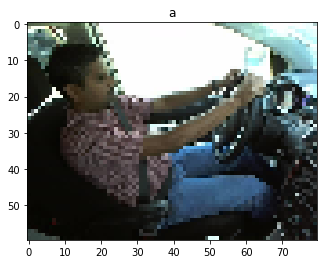

In [7]:
path = os.path.join( 'data','imgs', 'train', 'c0', 'img_34.jpg')
import matplotlib.image as mpimg
img=mpimg.imread(path)
resized = cv2.resize(img, (80, 60), cv2.INTER_LINEAR)
plt.title('a')
plt.imshow(resized)
plt.show()

In [2]:
#module

def get_im_cv2(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    elif color_type == 3:
        img = cv2.imread(path)
    # Reduce size
    resized = cv2.resize(img, (img_cols, img_rows))
    return resized


def get_im_cv2_mod(path, img_rows, img_cols, color_type=1):
    # Load as grayscale
    if color_type == 1:
        img = cv2.imread(path, 0)
    else:
        img = cv2.imread(path)
    # Reduce size
    #rotate = random.uniform(-10, 10)
    #M = cv2.getRotationMatrix2D((img.shape[1]/2, img.shape[0]/2), rotate, 1)
    #img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    resized = cv2.resize(img, (img_cols, img_rows), cv2.INTER_LINEAR)
    return resized
    

def get_driver_data():
    dr = dict()
    path = os.path.join( 'data', 'driver_imgs_list.csv')
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
    f.close()
    return dr


def load_train(img_rows, img_cols, color_type=1):
    X_train = []
    y_train = []
    driver_id = []
    start_time = time.time()
    driver_data = get_driver_data()

    print('Read train images')
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'data','imgs', 'train', 'c' + str(j), '*.jpg')
        files = glob.glob(path)
        for fl in files[0:int(len(files)/2)]:
            flbase = os.path.basename(fl)
            img = get_im_cv2_mod(fl, img_rows, img_cols, color_type)
            X_train.append(img)
            y_train.append(j)
            driver_id.append(driver_data[flbase])

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return X_train, y_train, driver_id, unique_drivers


def load_test(img_rows, img_cols, color_type=1):
    print('Read test images')
    start_time = time.time()
    path = os.path.join( 'data', 'imgs','test', '*.jpg')
    files = glob.glob(path)
    X_test = []
    X_test_id = []
    total = 0
    thr = math.floor(len(files)/10)
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2_mod(fl, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(flbase)
        total += 1
        if total%thr == 0:
            print('Read {} images from {}'.format(total, len(files)))
    
    print('Read test data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, X_test_id


def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()
    else:
        print('Directory doesnt exists')


def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data


def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'architecture.json'), 'w').write(json_string)
    model.save_weights(os.path.join('cache', 'model_weights.h5'), overwrite=True)


def read_model():
    model = model_from_json(open(os.path.join('cache', 'architecture.json')).read())
    model.load_weights(os.path.join('cache', 'model_weights.h5'))
    return model


def split_validation_set(train, target, test_size):
    random_state = 51
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)


def read_and_normalize_train_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'train_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        train_data, train_target, driver_id, unique_drivers = load_train(img_rows, img_cols, color_type)
        cache_data((train_data, train_target, driver_id, unique_drivers), cache_path)
    else:
        print('Restore train from cache!')
        (train_data, train_target, driver_id, unique_drivers) = restore_data(cache_path)

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)
    train_data = train_data.reshape(train_data.shape[0], img_rows, img_cols, color_type)
    train_target = np_utils.to_categorical(train_target, 10)
    train_data = train_data.astype('float32')
    train_data /= 255
    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, driver_id, unique_drivers


def read_and_normalize_test_data(img_rows, img_cols, color_type=1):
    cache_path = os.path.join('cache', 'test_r_' + str(img_rows) + '_c_' + str(img_cols) + '_t_' + str(color_type) + '.dat')
    if not os.path.isfile(cache_path) or use_cache == 0:
        test_data, test_id = load_test(img_rows, img_cols, color_type)
        cache_data((test_data, test_id), cache_path)
    else:
        print('Restore test from cache!')
        (test_data, test_id) = restore_data(cache_path)

    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, color_type)
    test_data = test_data.astype('float32')
    test_data /= 255
    print('Test shape:', test_data.shape)
    print(test_data.shape[0], 'test samples')
    return test_data, test_id


def dict_to_list(d):
    ret = []
    for i in d.items():
        ret.append(i[1])
    return ret


def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()


def merge_several_folds_geom(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a *= np.array(data[i])
    a = np.power(a, 1/nfolds)
    return a.tolist()


def copy_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
    index = []
    for i in range(len(driver_id)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            index.append(i)
    data = np.array(data, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    index = np.array(index, dtype=np.uint32)
    return data, target, index

from keras.layers import *
from keras.models import Model
import h5py

def create_model_v1(img_rows, img_cols, color_type=1):
    

    
    # Block 1
    img_input=Input((img_rows, img_cols, color_type))
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(10, activation='softmax', name='predictions')(x)
    #img_input=Input((img_rows, img_cols, color_type))
    model = Model(input=img_input, output=x)
    """
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,150,150)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2),dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2),dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2),dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2),dim_ordering="th"))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2),dim_ordering="th"))

    f = h5py.File('vgg16_weights.h5')
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        # set the weights to layer-k
        model.layers[k].set_weights(weights)
    f.close()
        
    print('VGG16 model weights have been successfully loaded.')
    
    
    
    # build a MLP classifier model to put on top of the VGG16 model
    top_model = Sequential()
    # flateen the output of VGG16 model to 2D Numpy matrix (n*D)
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    # hidden layer of 256 neurons
    top_model.add(Dense(256, activation='relu'))
    # add dropout for the dense layer
    top_model.add(Dropout(0.5))
    # the output layer: we have 10 claases
    top_model.add(Dense(10, activation='softmax'))

    # connect the two models onto the VGG16 net
    model.add(top_model)

    # set the first 25 layers (up to the last conv block) of VGFG16 net to non-trainable (weights will not be updated)
    for layer in model.layers[:25]:
        layer.trainable=False
    
    #model.add(Flatten())
    #model.add(Dense(4096, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(4096, activation='relu'))
    #model.add(Dropout(0.5))
    #model.add(Dense(1000, activation='softmax'))
    
    #model.load_weights('vgg16_weights_tf_dim_ordering_tf_kernels.h5')
    
    #model.compile(Adam(lr=1e-3), loss='categorical_crossentropy')
    #from keras.applications.resnet50 import ResNet50
    #from keras.applications.resnet50 import preprocess_input,decode_predictions
    
    #model = ResNet50(weigths='imagenet')
    """
    return model

def VGG16(include_top=False, weights='imagenet',
          input_tensor=None, input_shape=(80,60,3),
          pooling=None,
          classes=10):
   
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      include_top=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(4096, activation='relu', name='fc1')(x)
        x = Dense(4096, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='vgg16')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if include_top:
                maxpool = model.get_layer(name='block5_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model


In [3]:
img_rows, img_cols = 80, 60
batch_size = 32
nb_epoch = 20
random_state = 51

train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
#test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)

Restore train from cache!
Train shape: (11209, 80, 60, 3)
11209 train samples


In [5]:
yfull_train = dict()
yfull_test = []
unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075']
X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
unique_list_valid = ['p081']
X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

print('Start Single Run')
print('Split train: ', len(X_train), len(Y_train))
print('Split valid: ', len(X_valid), len(Y_valid))
print('Train drivers: ', unique_list_train)
print('Test drivers: ', unique_list_valid)

#model = create_model_v1(img_rows, img_cols, color_type_global)
#model.add(Dense(10, activation='softmax'))

from keras.applications.vgg16 import VGG16
model = Sequential()
model.add(VGG16(include_top=False,input_shape=([80,60,3])))
model.add(Dense(10))

model.compile(Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

filepath = "weights.best.hdf5"
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list=[checkpoint]
#from keras.callbacks import EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 2)

model.fit(X_train, Y_train, batch_size=batch_size, epochs=100,
               verbose=2, validation_data=(X_valid, Y_valid), callbacks = callbacks_list)
    

Start Single Run
Split train:  10813 10813
Split valid:  396 396
Train drivers:  ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075']
Test drivers:  ['p081']


ValueError: Error when checking model target: expected dense_1 to have 4 dimensions, but got array with shape (10813, 10)

In [27]:
predictions_valid = model.predict(X_valid, batch_size=128, verbose=1)
score = log_loss(Y_valid, predictions_valid)
print('Score log_loss: ', score)

177/177 [==============================] - 2s     
Score log_loss:  2.30111829844


In [ ]:
 for i in range(len(test_index)):
    yfull_train[test_index[i]] = predictions_valid[i]

    # Store test predictions
    test_prediction = model.predict(test_data, batch_size=128)
    yfull_test.append(test_prediction)

    print('Final log_loss: {}, rows: {} cols: {} epoch: {}'.format(score, img_rows, img_cols, nb_epoch))
    info_string = 'loss_' + str(score) \
                    + '_r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_ep_' + str(nb_epoch)

Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 epoch: 1
Final log_loss: 1.9352683063491034, rows: 64 cols: 64 e

In [ ]:
# run

 img_rows, img_cols = 64, 64
    batch_size = 32
    nb_epoch = 1
    random_state = 51

    train_data, train_target, driver_id, unique_drivers = read_and_normalize_train_data(img_rows, img_cols, color_type_global)
    test_data, test_id = read_and_normalize_test_data(img_rows, img_cols, color_type_global)

    yfull_train = dict()
    yfull_test = []
    unique_list_train = ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024',
                     'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049',
                     'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072',
                     'p075']
    X_train, Y_train, train_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
    unique_list_valid = ['p081']
    X_valid, Y_valid, test_index = copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

    print('Start Single Run')
    print('Split train: ', len(X_train), len(Y_train))
    print('Split valid: ', len(X_valid), len(Y_valid))
    print('Train drivers: ', unique_list_train)
    print('Test drivers: ', unique_list_valid)

    model = create_model_v1(img_rows, img_cols, color_type_global)
    model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
              show_accuracy=True, verbose=1, validation_data=(X_valid, Y_valid))

    # score = model.evaluate(X_valid, Y_valid, show_accuracy=True, verbose=0)
    # print('Score log_loss: ', score[0])

    predictions_valid = model.predict(X_valid, batch_size=128, verbose=1)
    score = log_loss(Y_valid, predictions_valid)
    print('Score log_loss: ', score)

    # Store valid predictions
    for i in range(len(test_index)):
        yfull_train[test_index[i]] = predictions_valid[i]

    # Store test predictions
    test_prediction = model.predict(test_data, batch_size=128, verbose=1)
    yfull_test.append(test_prediction)

    print('Final log_loss: {}, rows: {} cols: {} epoch: {}'.format(score, img_rows, img_cols, nb_epoch))
    info_string = 'loss_' + str(score) \
                    + '_r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_ep_' + str(nb_epoch)

    test_res = merge_several_folds_mean(yfull_test, 1)
    create_submission(test_res, test_id, info_string)